In [1]:
from sklearn.metrics.pairwise import cosine_similarity

import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [2]:
# 사용자 / 기사 / 단어에 대한 더미 데이터 생성
users = ['user' + str(i) for i in range(1, 1001)]
categories = ['사회', '경제', '정치', '과학', '문화']
articles = [f"{category}기사{i}" for category in categories for i in range(1, 201)]
words = [f"{category}_{i}" for category in categories for i in range(1, 201)]

article_word_df = pd.DataFrame(data = np.zeros((1000, 1000), dtype = int), index = articles, columns = words)
user_word_df = pd.DataFrame(data = np.zeros((1000, 1000), dtype = int), index = users, columns = words)

# 사용자 별로 선호하는 카테고리 설정
user_preferences = [category for category in categories for _ in range(200)]

# 사용자 별 경향성을 반영하여 선호하는 카테고리의 단어를 더 많이 학습
for i, user in enumerate(users):
    preferred_category = user_preferences[i]
    preferred_words = [word for word in words if preferred_category in word]
    non_preferred_words = [word for word in words if preferred_category not in word]

    # 선호하는 카테고리의 단어 중 10~15%를 무작위로 선택하여 학습 횟수를 0으로 설정
    num_to_exclude = int(len(preferred_words) * np.random.uniform(0.1, 0.15))
    excluded_words = np.random.choice(preferred_words, size = num_to_exclude, replace = False)

    for word in preferred_words:
        if word not in excluded_words:
            user_word_df.at[user, word] = np.random.randint(5, 11)
        else:
            user_word_df.at[user, word] = 0

    for word in non_preferred_words:
        user_word_df.at[user, word] = np.random.randint(0, 5)

article_categories = [category for category in categories for _ in range(200)]

# 기사별 카테고리에 따라 TF-IDF 값 조정
for i, article in enumerate(article_word_df.index):
    category = article_categories[i]
    category_words = [word for word in article_word_df.columns if category in word]
    non_category_words = [word for word in article_word_df.columns if category not in word]

    # 해당 카테고리의 단어 중 10~15%를 무작위로 선택하여 TF-IDF 값을 0으로 설정
    num_to_exclude = int(len(category_words) * np.random.uniform(0.1, 0.15))
    excluded_words = np.random.choice(category_words, size = num_to_exclude, replace = False)

    for word in category_words:
        if word not in excluded_words:
            article_word_df.at[article, word] = np.random.uniform(0.5, 1)
        else:
            article_word_df.at[article, word] = 0  # 명시적으로 0으로 설정

    for word in non_category_words:
        article_word_df.at[article, word] = np.random.uniform(0, 0.5)

In [3]:
user_word_df

,사회_1,사회_2,사회_3,사회_4,사회_5,사회_6,사회_7,사회_8,사회_9,사회_10,...,문화_191,문화_192,문화_193,문화_194,문화_195,문화_196,문화_197,문화_198,문화_199,문화_200
user1,8,9,8,6,10,7,0,9,5,7,...,4,0,2,2,4,0,2,3,0,4
user2,9,10,5,10,5,5,5,6,5,7,...,4,3,3,3,0,4,1,2,2,2
user3,6,8,6,5,10,5,5,6,5,7,...,0,4,0,2,0,1,0,0,3,4
user4,10,6,5,9,0,9,5,9,10,0,...,3,3,1,3,0,2,1,2,0,2
user5,10,9,8,8,7,0,10,0,7,7,...,3,1,2,4,2,1,3,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,4,4,4,4,2,3,2,2,4,2,...,6,5,10,9,5,10,9,9,0,9
user997,1,2,0,0,4,3,2,2,1,1,...,0,6,5,7,0,7,5,6,5,0
user998,3,1,4,0,3,1,2,0,3,2,...,10,6,9,5,5,10,5,5,0,6
user999,0,2,0,4,4,4,4,3,0,1,...,7,6,9,5,9,9,9,0,10,0


In [4]:
article_word_df

,사회_1,사회_2,사회_3,사회_4,사회_5,사회_6,사회_7,사회_8,사회_9,사회_10,...,문화_191,문화_192,문화_193,문화_194,문화_195,문화_196,문화_197,문화_198,문화_199,문화_200
사회기사1,0.924458,0.680401,0.543783,0.000000,0.807678,0.920326,0.794755,0.633304,0.000000,0.804399,...,0.044057,0.042025,0.114242,0.333226,0.426595,0.279988,0.392726,0.260141,0.334911,0.405499
사회기사2,0.654457,0.636861,0.683997,0.980135,0.711008,0.911304,0.000000,0.960985,0.718608,0.878239,...,0.197411,0.230128,0.239574,0.301839,0.328414,0.209710,0.220449,0.035931,0.155785,0.287997
사회기사3,0.954043,0.788445,0.969275,0.812780,0.000000,0.000000,0.934395,0.666120,0.000000,0.791417,...,0.145917,0.317490,0.204307,0.293583,0.087424,0.199109,0.148974,0.028711,0.168067,0.165282
사회기사4,0.903926,0.835874,0.898340,0.662692,0.527749,0.751000,0.000000,0.760673,0.938741,0.671916,...,0.354405,0.058558,0.136081,0.120623,0.364519,0.274905,0.077336,0.194709,0.463608,0.173766
사회기사5,0.915282,0.894369,0.765630,0.867845,0.682839,0.837853,0.783547,0.929647,0.557940,0.733202,...,0.116961,0.390641,0.425834,0.431661,0.173921,0.134263,0.403517,0.184944,0.105036,0.365311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
문화기사196,0.436813,0.187152,0.096254,0.344807,0.304938,0.307957,0.200605,0.169987,0.087629,0.355203,...,0.000000,0.861097,0.956943,0.994187,0.890954,0.911366,0.739480,0.679658,0.000000,0.713252
문화기사197,0.330292,0.165757,0.489820,0.352051,0.308806,0.459055,0.005617,0.214917,0.384449,0.177013,...,0.764927,0.778881,0.754291,0.890185,0.737687,0.706700,0.530238,0.521573,0.900867,0.000000
문화기사198,0.049950,0.339443,0.092619,0.198433,0.276054,0.363162,0.411380,0.352969,0.021503,0.265790,...,0.750352,0.762652,0.000000,0.879379,0.609479,0.921335,0.000000,0.755163,0.586940,0.595140
문화기사199,0.133834,0.479327,0.259311,0.175912,0.106452,0.144030,0.306251,0.108312,0.200576,0.353386,...,0.642301,0.526139,0.585946,0.666020,0.977426,0.690510,0.913304,0.000000,0.591268,0.850941


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/py

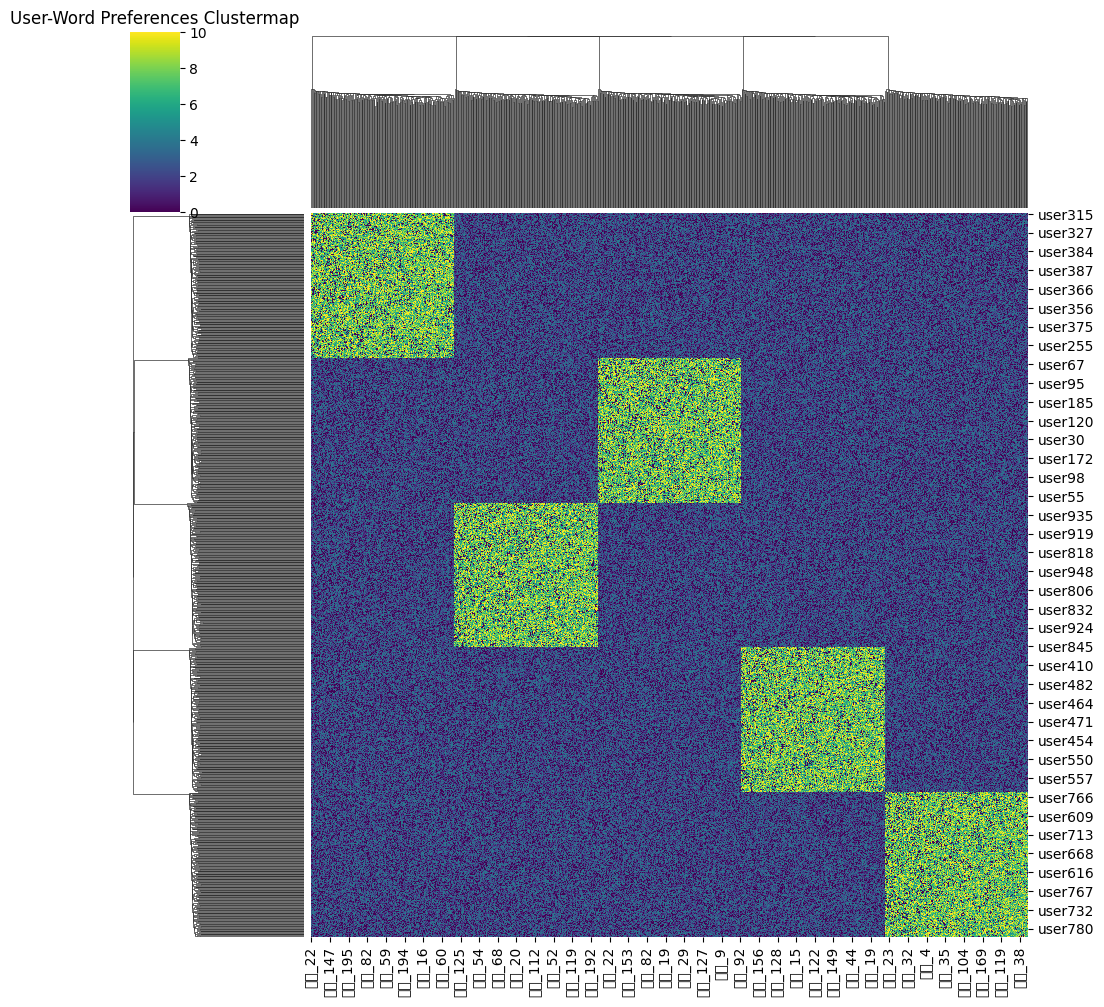

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


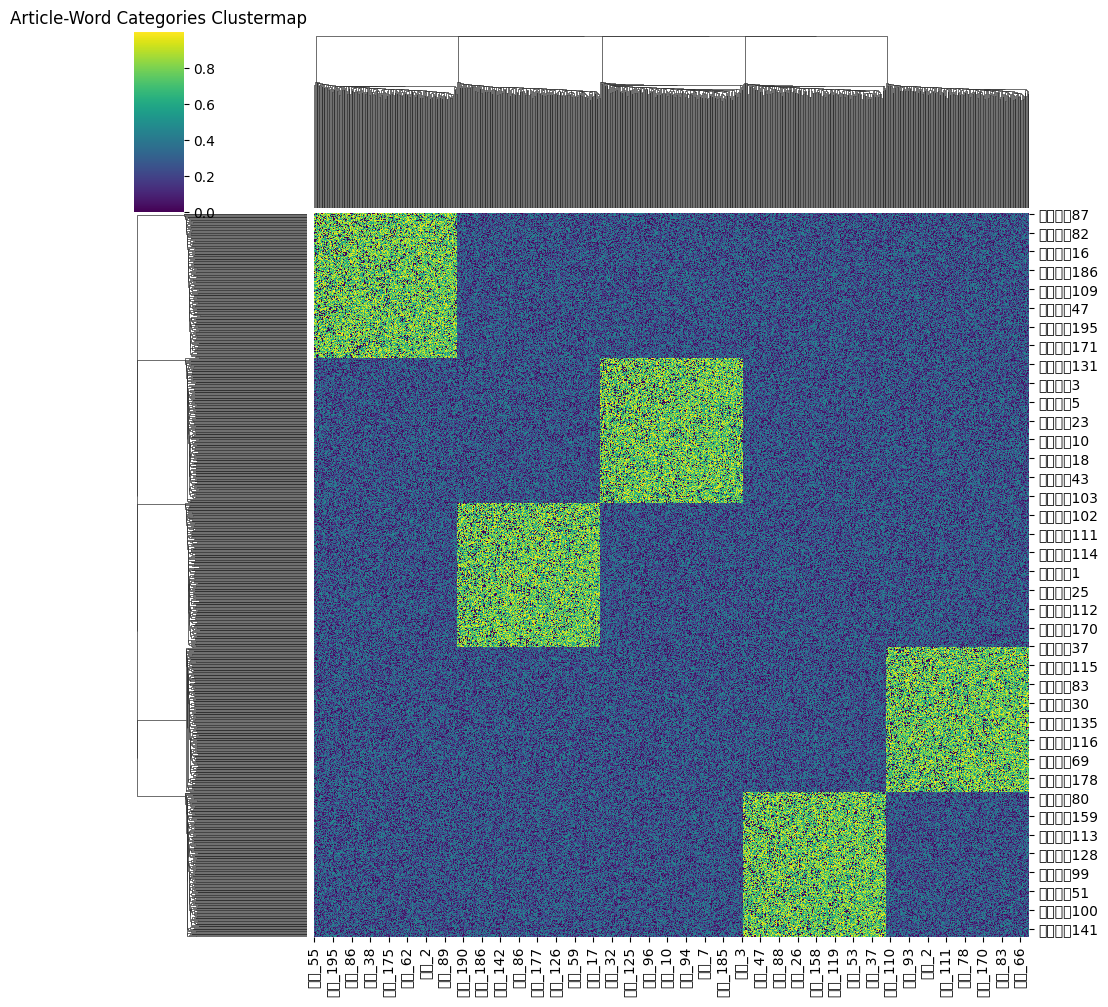

In [5]:
plt.rcParams['figure.figsize'] = (10, 8)  # 시각화 크기 설정
plt.rcParams['figure.dpi'] = 100  # 해상도 설정

# user_word_df 데이터프레임에 대한 Clustermap 생성
sns.clustermap(user_word_df, method = 'average', metric = 'euclidean', figsize = (10, 10), cmap = 'viridis')
plt.title("User-Word Preferences Clustermap")
plt.show()

# article_word_df 데이터프레임에 대한 Clustermap 생성
sns.clustermap(article_word_df, method = 'average', metric = 'euclidean', figsize = (10, 10), cmap = 'viridis')
plt.title("Article-Word Categories Clustermap")
plt.show()

In [6]:
# 데이터 간 Scale을 맞추기 위하여 Min-Max 정규화
user_word_df_norm = (user_word_df - user_word_df.min()) / (user_word_df.max() - user_word_df.min())
user_word_df_norm

,사회_1,사회_2,사회_3,사회_4,사회_5,사회_6,사회_7,사회_8,사회_9,사회_10,...,문화_191,문화_192,문화_193,문화_194,문화_195,문화_196,문화_197,문화_198,문화_199,문화_200
user1,0.8,0.9,0.8,0.6,1.0,0.7,0.0,0.9,0.5,0.7,...,0.4,0.0,0.2,0.2,0.4,0.0,0.2,0.3,0.0,0.4
user2,0.9,1.0,0.5,1.0,0.5,0.5,0.5,0.6,0.5,0.7,...,0.4,0.3,0.3,0.3,0.0,0.4,0.1,0.2,0.2,0.2
user3,0.6,0.8,0.6,0.5,1.0,0.5,0.5,0.6,0.5,0.7,...,0.0,0.4,0.0,0.2,0.0,0.1,0.0,0.0,0.3,0.4
user4,1.0,0.6,0.5,0.9,0.0,0.9,0.5,0.9,1.0,0.0,...,0.3,0.3,0.1,0.3,0.0,0.2,0.1,0.2,0.0,0.2
user5,1.0,0.9,0.8,0.8,0.7,0.0,1.0,0.0,0.7,0.7,...,0.3,0.1,0.2,0.4,0.2,0.1,0.3,0.3,0.3,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,0.4,0.4,0.4,0.4,0.2,0.3,0.2,0.2,0.4,0.2,...,0.6,0.5,1.0,0.9,0.5,1.0,0.9,0.9,0.0,0.9
user997,0.1,0.2,0.0,0.0,0.4,0.3,0.2,0.2,0.1,0.1,...,0.0,0.6,0.5,0.7,0.0,0.7,0.5,0.6,0.5,0.0
user998,0.3,0.1,0.4,0.0,0.3,0.1,0.2,0.0,0.3,0.2,...,1.0,0.6,0.9,0.5,0.5,1.0,0.5,0.5,0.0,0.6
user999,0.0,0.2,0.0,0.4,0.4,0.4,0.4,0.3,0.0,0.1,...,0.7,0.6,0.9,0.5,0.9,0.9,0.9,0.0,1.0,0.0


In [7]:
# 뉴스 기사 추천 : Cosine 유사도 기반 Content-Based Filtering Algorithm
# 코사인 유사도 기반으로 사용자와 관련성이 높은 기사를 추천하는 방법

# 사용자 - 기사 간 코사인 유사도 계산
cosine_sim = cosine_similarity(user_word_df_norm, article_word_df)

# 코사인 유사도를 DataFrame으로 변환
cosine_sim_df = pd.DataFrame(cosine_sim, columns = articles, index = users)
cosine_sim_df

,사회기사1,사회기사2,사회기사3,사회기사4,사회기사5,사회기사6,사회기사7,사회기사8,사회기사9,사회기사10,...,문화기사191,문화기사192,문화기사193,문화기사194,문화기사195,문화기사196,문화기사197,문화기사198,문화기사199,문화기사200
user1,0.793945,0.803696,0.777776,0.779806,0.801364,0.777078,0.821952,0.780676,0.769832,0.785056,...,0.570187,0.582430,0.579588,0.568626,0.581780,0.565758,0.573757,0.567568,0.570498,0.593205
user2,0.799791,0.790267,0.786977,0.815020,0.800796,0.799432,0.817080,0.788667,0.789719,0.819479,...,0.562213,0.591399,0.565480,0.568354,0.567114,0.557593,0.575569,0.567419,0.565311,0.579792
user3,0.789586,0.788720,0.784971,0.779616,0.810848,0.785724,0.796003,0.769057,0.787703,0.798631,...,0.548470,0.552758,0.555874,0.554463,0.539091,0.528580,0.541471,0.547180,0.532524,0.545036
user4,0.793979,0.790854,0.779162,0.800057,0.802618,0.798614,0.790100,0.785073,0.794186,0.791609,...,0.563654,0.574624,0.562581,0.577728,0.559817,0.548158,0.570689,0.562465,0.564436,0.566487
user5,0.795288,0.798730,0.783789,0.793175,0.814097,0.778561,0.803439,0.806850,0.805197,0.787939,...,0.577290,0.567568,0.566901,0.563918,0.562223,0.555405,0.572318,0.550735,0.546691,0.566047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,0.564206,0.555443,0.557054,0.547282,0.581495,0.563105,0.555778,0.554875,0.560284,0.573691,...,0.776730,0.771647,0.762970,0.768189,0.784850,0.785173,0.788152,0.776548,0.767314,0.788677
user997,0.545510,0.547628,0.553672,0.554271,0.564820,0.548428,0.545535,0.554103,0.546216,0.564480,...,0.789528,0.788673,0.790595,0.803882,0.809814,0.792884,0.789393,0.804571,0.790030,0.809862
user998,0.555600,0.550094,0.547528,0.554187,0.575373,0.559170,0.557328,0.556955,0.561435,0.557882,...,0.791735,0.768812,0.781817,0.780420,0.770541,0.788320,0.782724,0.790217,0.767969,0.776960
user999,0.537510,0.542142,0.546842,0.541759,0.575474,0.554892,0.542610,0.555766,0.543636,0.549258,...,0.791739,0.790135,0.787008,0.783881,0.783171,0.777565,0.807063,0.770842,0.765032,0.787508


In [8]:
# 각 사용자에 대한 추천 리스트 생성하여 추천 점수가 높은 기사 추천

# 실제로 구현할 때는 해당 기사가 이미 읽었던 기사인지, 아닌지 검증하는 과정 추가 필요

recommendations = {}
for user in users:
    user_data = cosine_sim_df.loc[user].sort_values(ascending = False)
    recommendations[user] = user_data.index.values.tolist()[:3]

print(recommendations)

{'user1': ['사회기사7', '사회기사55', '사회기사38'], 'user2': ['사회기사147', '사회기사10', '사회기사24'], 'user3': ['사회기사17', '사회기사70', '사회기사124'], 'user4': ['사회기사144', '사회기사199', '사회기사167'], 'user5': ['사회기사55', '사회기사166', '사회기사84'], 'user6': ['사회기사36', '사회기사24', '사회기사43'], 'user7': ['사회기사24', '사회기사196', '사회기사149'], 'user8': ['사회기사67', '사회기사17', '사회기사169'], 'user9': ['사회기사105', '사회기사147', '사회기사45'], 'user10': ['사회기사194', '사회기사14', '사회기사56'], 'user11': ['사회기사195', '사회기사188', '사회기사96'], 'user12': ['사회기사10', '사회기사62', '사회기사75'], 'user13': ['사회기사138', '사회기사43', '사회기사147'], 'user14': ['사회기사149', '사회기사196', '사회기사171'], 'user15': ['사회기사25', '사회기사184', '사회기사24'], 'user16': ['사회기사24', '사회기사42', '사회기사63'], 'user17': ['사회기사189', '사회기사170', '사회기사182'], 'user18': ['사회기사123', '사회기사117', '사회기사149'], 'user19': ['사회기사182', '사회기사121', '사회기사56'], 'user20': ['사회기사30', '사회기사51', '사회기사196'], 'user21': ['사회기사39', '사회기사5', '사회기사81'], 'user22': ['사회기사127', '사회기사103', '사회기사27'], 'user23': ['사회기사196', '사회기사84', '사회기사4'], 'user24': ['사

In [9]:
# 단어 추천 방법 1 : 해당 사용자가 아직 학습하지 않은 단어들 중 해당 사용자와 유사한 사용자들이 많이 학습한 단어를 추천하는 알고리즘

# 사용자 간 유사도 계산
user_similarity = cosine_similarity(user_word_df_norm)

# 유사도를 DataFrame으로 변환
user_similarity_df = pd.DataFrame(user_similarity, index = users, columns = users)
user_similarity_df

,user1,user2,user3,user4,user5,user6,user7,user8,user9,user10,...,user991,user992,user993,user994,user995,user996,user997,user998,user999,user1000
user1,1.000000,0.786758,0.765912,0.763329,0.781172,0.763963,0.765738,0.767067,0.790540,0.781318,...,0.536092,0.519145,0.522685,0.513234,0.534965,0.509424,0.501541,0.517060,0.501180,0.522741
user2,0.786758,1.000000,0.781094,0.788320,0.784132,0.778494,0.788679,0.792308,0.782949,0.796402,...,0.522616,0.510011,0.518734,0.517620,0.521968,0.526108,0.509389,0.510343,0.512963,0.518417
user3,0.765912,0.781094,1.000000,0.785473,0.779310,0.766301,0.782567,0.783336,0.778178,0.767389,...,0.499737,0.483228,0.505557,0.489231,0.511201,0.504867,0.490896,0.504740,0.489093,0.498137
user4,0.763329,0.788320,0.785473,1.000000,0.783412,0.780705,0.793844,0.780764,0.776357,0.803964,...,0.526680,0.520206,0.522270,0.496439,0.529549,0.514337,0.507247,0.517669,0.502161,0.523365
user5,0.781172,0.784132,0.779310,0.783412,1.000000,0.779945,0.801588,0.785118,0.780239,0.786011,...,0.521691,0.509649,0.522190,0.513296,0.521834,0.524436,0.491146,0.508311,0.514360,0.518599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user996,0.509424,0.526108,0.504867,0.514337,0.524436,0.509843,0.506165,0.526052,0.499912,0.508663,...,0.781628,0.767445,0.778753,0.758412,0.763635,1.000000,0.794763,0.768046,0.764973,0.771727
user997,0.501541,0.509389,0.490896,0.507247,0.491146,0.510760,0.479238,0.503769,0.490345,0.495528,...,0.781817,0.801212,0.776218,0.776864,0.777982,0.794763,1.000000,0.789150,0.809033,0.803727
user998,0.517060,0.510343,0.504740,0.517669,0.508311,0.515034,0.506973,0.522457,0.508551,0.505508,...,0.772882,0.789487,0.790133,0.778259,0.760356,0.768046,0.789150,1.000000,0.786418,0.778786
user999,0.501180,0.512963,0.489093,0.502161,0.514360,0.499215,0.504889,0.497548,0.504822,0.495835,...,0.771507,0.778012,0.767527,0.772516,0.767749,0.764973,0.809033,0.786418,1.000000,0.781205


In [12]:
# 사용자가 아직 학습하지 않은 단어 찾기
unlearned_words = user_word_df_norm.apply(lambda x: x == 0)

# 추천 단어 리스트 생성
word_recommendations = {}
for user in users:
    # 사용자와 유사한 사용자들 찾기
    similar_users = user_similarity_df[user].sort_values(ascending=False).index[1:]

    # 유사한 사용자들이 많이 학습한 단어 찾기
    similar_users_words = user_word_df_norm.loc[similar_users].mean().sort_values(ascending=False)

    # 사용자가 아직 학습하지 않은 단어 중에서 유사한 사용자들이 많이 학습한 단어 선택
    user_unlearned_words = unlearned_words.loc[user]
    recommended_words = similar_users_words[user_unlearned_words].sort_values(ascending=False)

    # 상위 3개 단어 추천
    word_recommendations[user] = recommended_words.index[:3].tolist()

In [13]:
print(word_recommendations)

{'user1': ['정치_4', '사회_82', '과학_116'], 'user2': ['정치_153', '과학_116', '사회_24'], 'user3': ['경제_128', '경제_75', '문화_80'], 'user4': ['과학_123', '경제_75', '문화_80'], 'user5': ['정치_153', '과학_144', '과학_1'], 'user6': ['사회_194', '과학_150', '과학_144'], 'user7': ['과학_101', '정치_153', '과학_116'], 'user8': ['과학_150', '과학_195', '과학_36'], 'user9': ['정치_71', '과학_101', '과학_36'], 'user10': ['과학_101', '과학_116', '과학_36'], 'user11': ['정치_4', '과학_101', '과학_123'], 'user12': ['정치_4', '정치_71', '정치_153'], 'user13': ['과학_116', '과학_144', '과학_195'], 'user14': ['과학_101', '정치_153', '경제_128'], 'user15': ['정치_4', '사회_194', '정치_71'], 'user16': ['사회_194', '사회_82', '경제_75'], 'user17': ['사회_194', '사회_82', '과학_150'], 'user18': ['정치_71', '과학_144', '과학_195'], 'user19': ['과학_195', '정치_117', '경제_34'], 'user20': ['과학_144', '문화_80', '경제_4'], 'user21': ['정치_4', '사회_194', '과학_101'], 'user22': ['정치_71', '과학_116', '문화_155'], 'user23': ['정치_71', '과학_195', '문화_192'], 'user24': ['과학_195', '과학_36', '과학_126'], 'user25': ['과학_101', '과학_150', '과학_

In [14]:
# 단어 추천 방법 2 : Matrix Factorization
# 행렬을 두 개의 저차원 행렬로 분해하여 각각 사용자와 단어의 잠재적 특성을 나타냄
# 잠재적 특성을 기반으로 사용자와 단어 사이의 관계를 예측

# 행렬 분해 모델 클래스 정의
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, dropout_rate=0.5, l2=0.01):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.l2 = l2

        nn.init.normal_(self.user_embedding.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.item_embedding.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_indices, item_indices):
        user_latent = self.dropout(self.user_embedding(user_indices))
        item_latent = self.dropout(self.item_embedding(item_indices))
        user_bias = self.user_bias(user_indices).squeeze()
        item_bias = self.item_bias(item_indices).squeeze()

        prediction = torch.sum(user_latent * item_latent, dim=1) + user_bias + item_bias
        return prediction

    def loss(self, prediction, target):
        loss = F.mse_loss(prediction, target)
        l2_reg = (self.user_embedding.weight.norm(2).pow(2) + self.item_embedding.weight.norm(2).pow(2) + self.user_bias.weight.norm(2).pow(2) + self.item_bias.weight.norm(2).pow(2)) * self.l2 / 2
        return loss + l2_reg

# 데이터셋 클래스 정의
class UserWordDataset(Dataset):
    def __init__(self, data):
        self.users = {user: idx for idx, user in enumerate(data.index)}
        self.items = {item: idx for idx, item in enumerate(data.columns)}
        self.ratings = data.values.flatten().astype(np.float32)

        user_indices = [self.users[user] for user in data.index.repeat(len(data.columns))]
        item_indices = [self.items[item] for item in np.tile(data.columns, len(data.index))]

        self.user_indices = np.array(user_indices)
        self.item_indices = np.array(item_indices)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user = torch.tensor(self.user_indices[idx], dtype=torch.long)
        item = torch.tensor(self.item_indices[idx], dtype=torch.long)
        rating = torch.tensor(self.ratings[idx], dtype=torch.float)
        return user, item, rating

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RMSE 계산 함수
def compute_rmse(predictions, ratings):
    return torch.sqrt(torch.mean((predictions - ratings) ** 2))

# 데이터 로딩
dataset = UserWordDataset(user_word_df)  # 데이터셋을 디바이스로 옮김
train_size = int(0.8 * len(dataset))
test_valid_size = len(dataset) - train_size
valid_size = test_valid_size // 2
test_size = valid_size

# 데이터셋 분할
train_dataset, test_valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_valid_size])
test_dataset, valid_dataset = torch.utils.data.random_split(test_valid_dataset, [test_size, valid_size])

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

# 모델 초기화
num_users, num_items = len(user_word_df.index), len(user_word_df.columns)
model = MatrixFactorization(num_users, num_items, latent_dim = 200, dropout_rate = 0.5).to(device)

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr = 0.005)

# 학습 진행
best_val_loss = float('inf')
for epoch in range(10):
    model.train()
    train_losses = []
    for user_indices, item_indices, ratings in train_loader:
        user_indices, item_indices, ratings = user_indices.to(device), item_indices.to(device), ratings.to(device)
        prediction = model(user_indices, item_indices)
        loss = model.loss(prediction, ratings)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss}")

    # 검증 손실 계산
    model.eval()
    total_loss = 0
    total_rmse = 0
    with torch.no_grad():
        for user_indices, item_indices, ratings in valid_loader:
            user_indices, item_indices, ratings = user_indices.to(device), item_indices.to(device), ratings.to(device)
            prediction = model(user_indices, item_indices)
            loss = model.loss(prediction, ratings)
            rmse = compute_rmse(prediction, ratings)

            total_loss += loss.item()
            total_rmse += rmse.item()

    avg_val_loss = total_loss / len(valid_loader)
    avg_val_rmse = total_rmse / len(valid_loader)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss}, RMSE: {avg_val_rmse}")

    # 모델 저장
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_content = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }
        torch.save(save_content, 'best_model.pth')

# 테스트 데이터셋을 사용한 모델 평가
model.eval()
total_test_loss = 0
total_test_rmse = 0
with torch.no_grad():
    for user_indices, item_indices, ratings in test_loader:
        user_indices, item_indices, ratings = user_indices.to(device), item_indices.to(device), ratings.to(device)
        prediction = model(user_indices, item_indices)
        loss = model.loss(prediction, ratings)
        rmse = compute_rmse(prediction, ratings)

        total_test_loss += loss.item()
        total_test_rmse += rmse.item()
avg_test_loss = total_test_loss / len(test_loader)
avg_test_rmse = total_test_rmse / len(test_loader)
print(f"Final Test Loss: {avg_test_loss}, RMSE: {avg_test_rmse}")

Epoch 1 Training Loss: 12.880209474487305
Epoch 1 Validation Loss: 12.860632096508414, RMSE: 3.3055752479946166
Epoch 2 Training Loss: 12.838590727272035
Epoch 2 Validation Loss: 12.865841213282453, RMSE: 3.305623261042306
Epoch 3 Training Loss: 12.839139800834655
Epoch 3 Validation Loss: 12.858209678017781, RMSE: 3.3025147486251667
Epoch 4 Training Loss: 12.838992193336487
Epoch 4 Validation Loss: 12.85528796617602, RMSE: 3.306567668457178
Epoch 5 Training Loss: 12.838374131393433
Epoch 5 Validation Loss: 12.857023412115057, RMSE: 3.301689806765497
Epoch 6 Training Loss: 12.838785278053283
Epoch 6 Validation Loss: 12.859468216630638, RMSE: 3.306029525690939
Epoch 7 Training Loss: 12.83865556022644
Epoch 7 Validation Loss: 12.864711183351503, RMSE: 3.305457412777081
Epoch 8 Training Loss: 12.839235046081543
Epoch 8 Validation Loss: 12.854799169038857, RMSE: 3.3066814063225354
Epoch 9 Training Loss: 12.83871647239685
Epoch 9 Validation Loss: 12.866819489406456, RMSE: 3.308825294558085
E

In [16]:
for user_index in range(num_users):
    untrained_item_indices = []
    untrained_item_names = user_word_df.iloc[user_index][user_word_df.iloc[user_index] == 0].index.tolist()
    for item_name in untrained_item_names:
        item_index = dataset.items[item_name]
        untrained_item_indices.append(item_index)

    untrained_item_indices_tensor = torch.tensor(untrained_item_indices, dtype=torch.long, device=device)
    # 예측을 수행
    predictions = model(torch.tensor([user_index] * len(untrained_item_indices), device=device), untrained_item_indices_tensor)
    # 가장 높은 예측 점수를 가진 아이템 인덱스를 추천
    recommended_item_index = untrained_item_indices[torch.argmax(predictions).item()]
    # 추천된 아이템 인덱스를 다시 아이템 이름으로 변환하여 출력
    recommended_item_name = list(dataset.items.keys())[list(dataset.items.values()).index(recommended_item_index)]
    print(f"User {user_index} recommended item: {recommended_item_name}")

User 0 recommended item: 사회_42
User 1 recommended item: 경제_59
User 2 recommended item: 정치_109
User 3 recommended item: 정치_126
User 4 recommended item: 과학_194
User 5 recommended item: 정치_109
User 6 recommended item: 문화_47
User 7 recommended item: 사회_42
User 8 recommended item: 사회_103
User 9 recommended item: 사회_42
User 10 recommended item: 과학_149
User 11 recommended item: 정치_4
User 12 recommended item: 정치_126
User 13 recommended item: 사회_187
User 14 recommended item: 정치_4
User 15 recommended item: 과학_57
User 16 recommended item: 사회_150
User 17 recommended item: 경제_179
User 18 recommended item: 정치_61
User 19 recommended item: 사회_103
User 20 recommended item: 정치_4
User 21 recommended item: 과학_149
User 22 recommended item: 과학_194
User 23 recommended item: 사회_118
User 24 recommended item: 문화_47
User 25 recommended item: 사회_142
User 26 recommended item: 정치_109
User 27 recommended item: 과학_194
User 28 recommended item: 과학_194
User 29 recommended item: 정치_109
User 30 recommended item: 사회_118
U